In [1]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.oauth2 as oauth2
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import random
from functools import reduce
from sklearn.ensemble import RandomForestRegressor
from datetime import date
import time


## Spotify API Call

In [2]:
client_id = '83c1f666855f45f89b2216e55c7bf535'
client_secret = '9bfd86b3fd3c43ada84e1f282fb1df35'
redirect_uri='http://localhost:8910/callback'
username = '61d4pmnwnwjt7xz9tj6v3txho'

scope = 'user-top-read'

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, 
                                                      client_secret=client_secret)
                                                      
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

token = util.prompt_for_user_token(username,scope, client_id, client_secret, redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)
    

## Top Tracks Extraction

In [51]:
results = sp.current_user_top_tracks(limit=50, offset=0,time_range='short_term')

#Convert the results into a dataframe
track_name = []
track_id = []
artist = []
new = []
album = []
duration = []
popularity = []
for i, items in enumerate(results['items']):
        track_name.append(items['name'])
        track_id.append(items['id'])
        artist.append(items["artists"][0]["name"])
        duration.append(items["duration_ms"])
        album.append(items["album"]["name"])
        popularity.append(items["popularity"])

# Create the final df   
df_top_tracks = pd.DataFrame({ "track_name": track_name, 
                             "album": album, 
                             "track_id": track_id,
                             "artist": artist, 
                             "duration": duration, 
                             "popularity": popularity})

df_top_tracks

,track_name,album,track_id,artist,duration,popularity
0,Vaathi Coming,Master (Original Motion Picture Soundtrack),2BcPFQ7nrtUObgAs72xaac,Anirudh Ravichander,228257,64
1,"Ey Inge Paaru (From ""Velaiyilla Pattathari"")",Voice of Ani,34hssXUwRCru1RbfxCWLth,Anirudh Ravichander,117788,24
2,Feels Like Love,Noah Schnacky EP,04hHPq6kXTbcSSDrdaP3s4,Noah Schnacky,174760,53
3,Andha Kanna Paathaakaa,Master (Original Motion Picture Soundtrack),0qvoxfYodIfe14gaidhnsV,Anirudh Ravichander,194500,65
4,All the Cowboys,All the Cowboys,13TOvHAfdO8wryqxBL7fnI,Alexandra Kay,228231,55
5,My Person,Wilderness,1MOOJuxUu9QiQE9GgkYYPb,Spencer Crandall,177000,59
6,Comeback,Noah Schnacky EP,1wr0HUe5tFDlN32jfwt9IS,Noah Schnacky,168240,49
7,Maybe We Will - 2020 Version,Noah Schnacky EP,26LKaGfw6ZolgGArPDEN2R,Noah Schnacky,190440,43
8,Polakattum Para Para,Master (Original Motion Picture Soundtrack),2K058s9yrpoUfANaQt7Zu4,Anirudh Ravichander,214124,55
9,"Neeyum Naanum (From ""Naanum Rowdy Dhaan"")",Voice of Ani,2XMJ3A06ex0UI9JRPeOYrQ,Anirudh Ravichander,301951,21


## Features Extraction

In [4]:
def get_features(sp,df):
    playlist = df[['track_id','track_name']]
    features = []
    
    features += sp.audio_features(playlist.iloc[0:50, 0])

    feature_list = []
    for feature in features:
        feature_list.append([feature['danceability'],
                        feature['energy'],
                        feature['key'],
                        feature['loudness'],
                        feature['mode'],
                        feature['speechiness'],
                        feature['acousticness'],
                        feature['instrumentalness'],
                        feature['liveness'],
                        feature['valence'],
                        feature['tempo'],
                        feature['duration_ms']]
                       )

    df_audio_feature = pd.DataFrame(feature_list, columns = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                                                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                                          'duration_ms'])
    df_playlist_audio_features = pd.concat([playlist, df_audio_feature], axis=1)
    return df_playlist_audio_features
    

In [5]:
df_final_features = get_features(sp,df_top_tracks)
#Drop the mode feature as it is binary
del df_final_features['mode']
df_final_features

,track_id,track_name,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,2BcPFQ7nrtUObgAs72xaac,Vaathi Coming,0.643,0.952,7,-4.150,0.2460,0.27600,0.490000,0.0588,0.585,164.784,228258
1,34hssXUwRCru1RbfxCWLth,"Ey Inge Paaru (From ""Velaiyilla Pattathari"")",0.643,0.834,7,-4.104,0.1820,0.06520,0.000042,0.6120,0.872,189.998,117788
2,04hHPq6kXTbcSSDrdaP3s4,Feels Like Love,0.639,0.845,2,-5.139,0.0414,0.00117,0.000000,0.1260,0.703,117.047,174760
3,0qvoxfYodIfe14gaidhnsV,Andha Kanna Paathaakaa,0.747,0.860,6,-4.071,0.2790,0.30100,0.038300,0.0743,0.625,90.445,194500
4,13TOvHAfdO8wryqxBL7fnI,All the Cowboys,0.501,0.554,9,-6.292,0.0265,0.32100,0.000000,0.1780,0.470,144.022,228232
5,1MOOJuxUu9QiQE9GgkYYPb,My Person,0.567,0.753,7,-5.291,0.0487,0.08940,0.000000,0.1300,0.756,165.966,177000
6,1wr0HUe5tFDlN32jfwt9IS,Comeback,0.542,0.817,11,-5.192,0.0324,0.03830,0.000000,0.2180,0.683,95.978,168240
7,26LKaGfw6ZolgGArPDEN2R,Maybe We Will - 2020 Version,0.685,0.485,4,-7.755,0.0272,0.15100,0.000000,0.1100,0.526,85.045,190440
8,2K058s9yrpoUfANaQt7Zu4,Polakattum Para Para,0.758,0.796,11,-6.483,0.1700,0.16500,0.000041,0.2900,0.919,145.475,214125
9,2XMJ3A06ex0UI9JRPeOYrQ,"Neeyum Naanum (From ""Naanum Rowdy Dhaan"")",0.572,0.620,9,-9.949,0.0436,0.10100,0.004880,0.1130,0.345,157.968,301951


## EDA

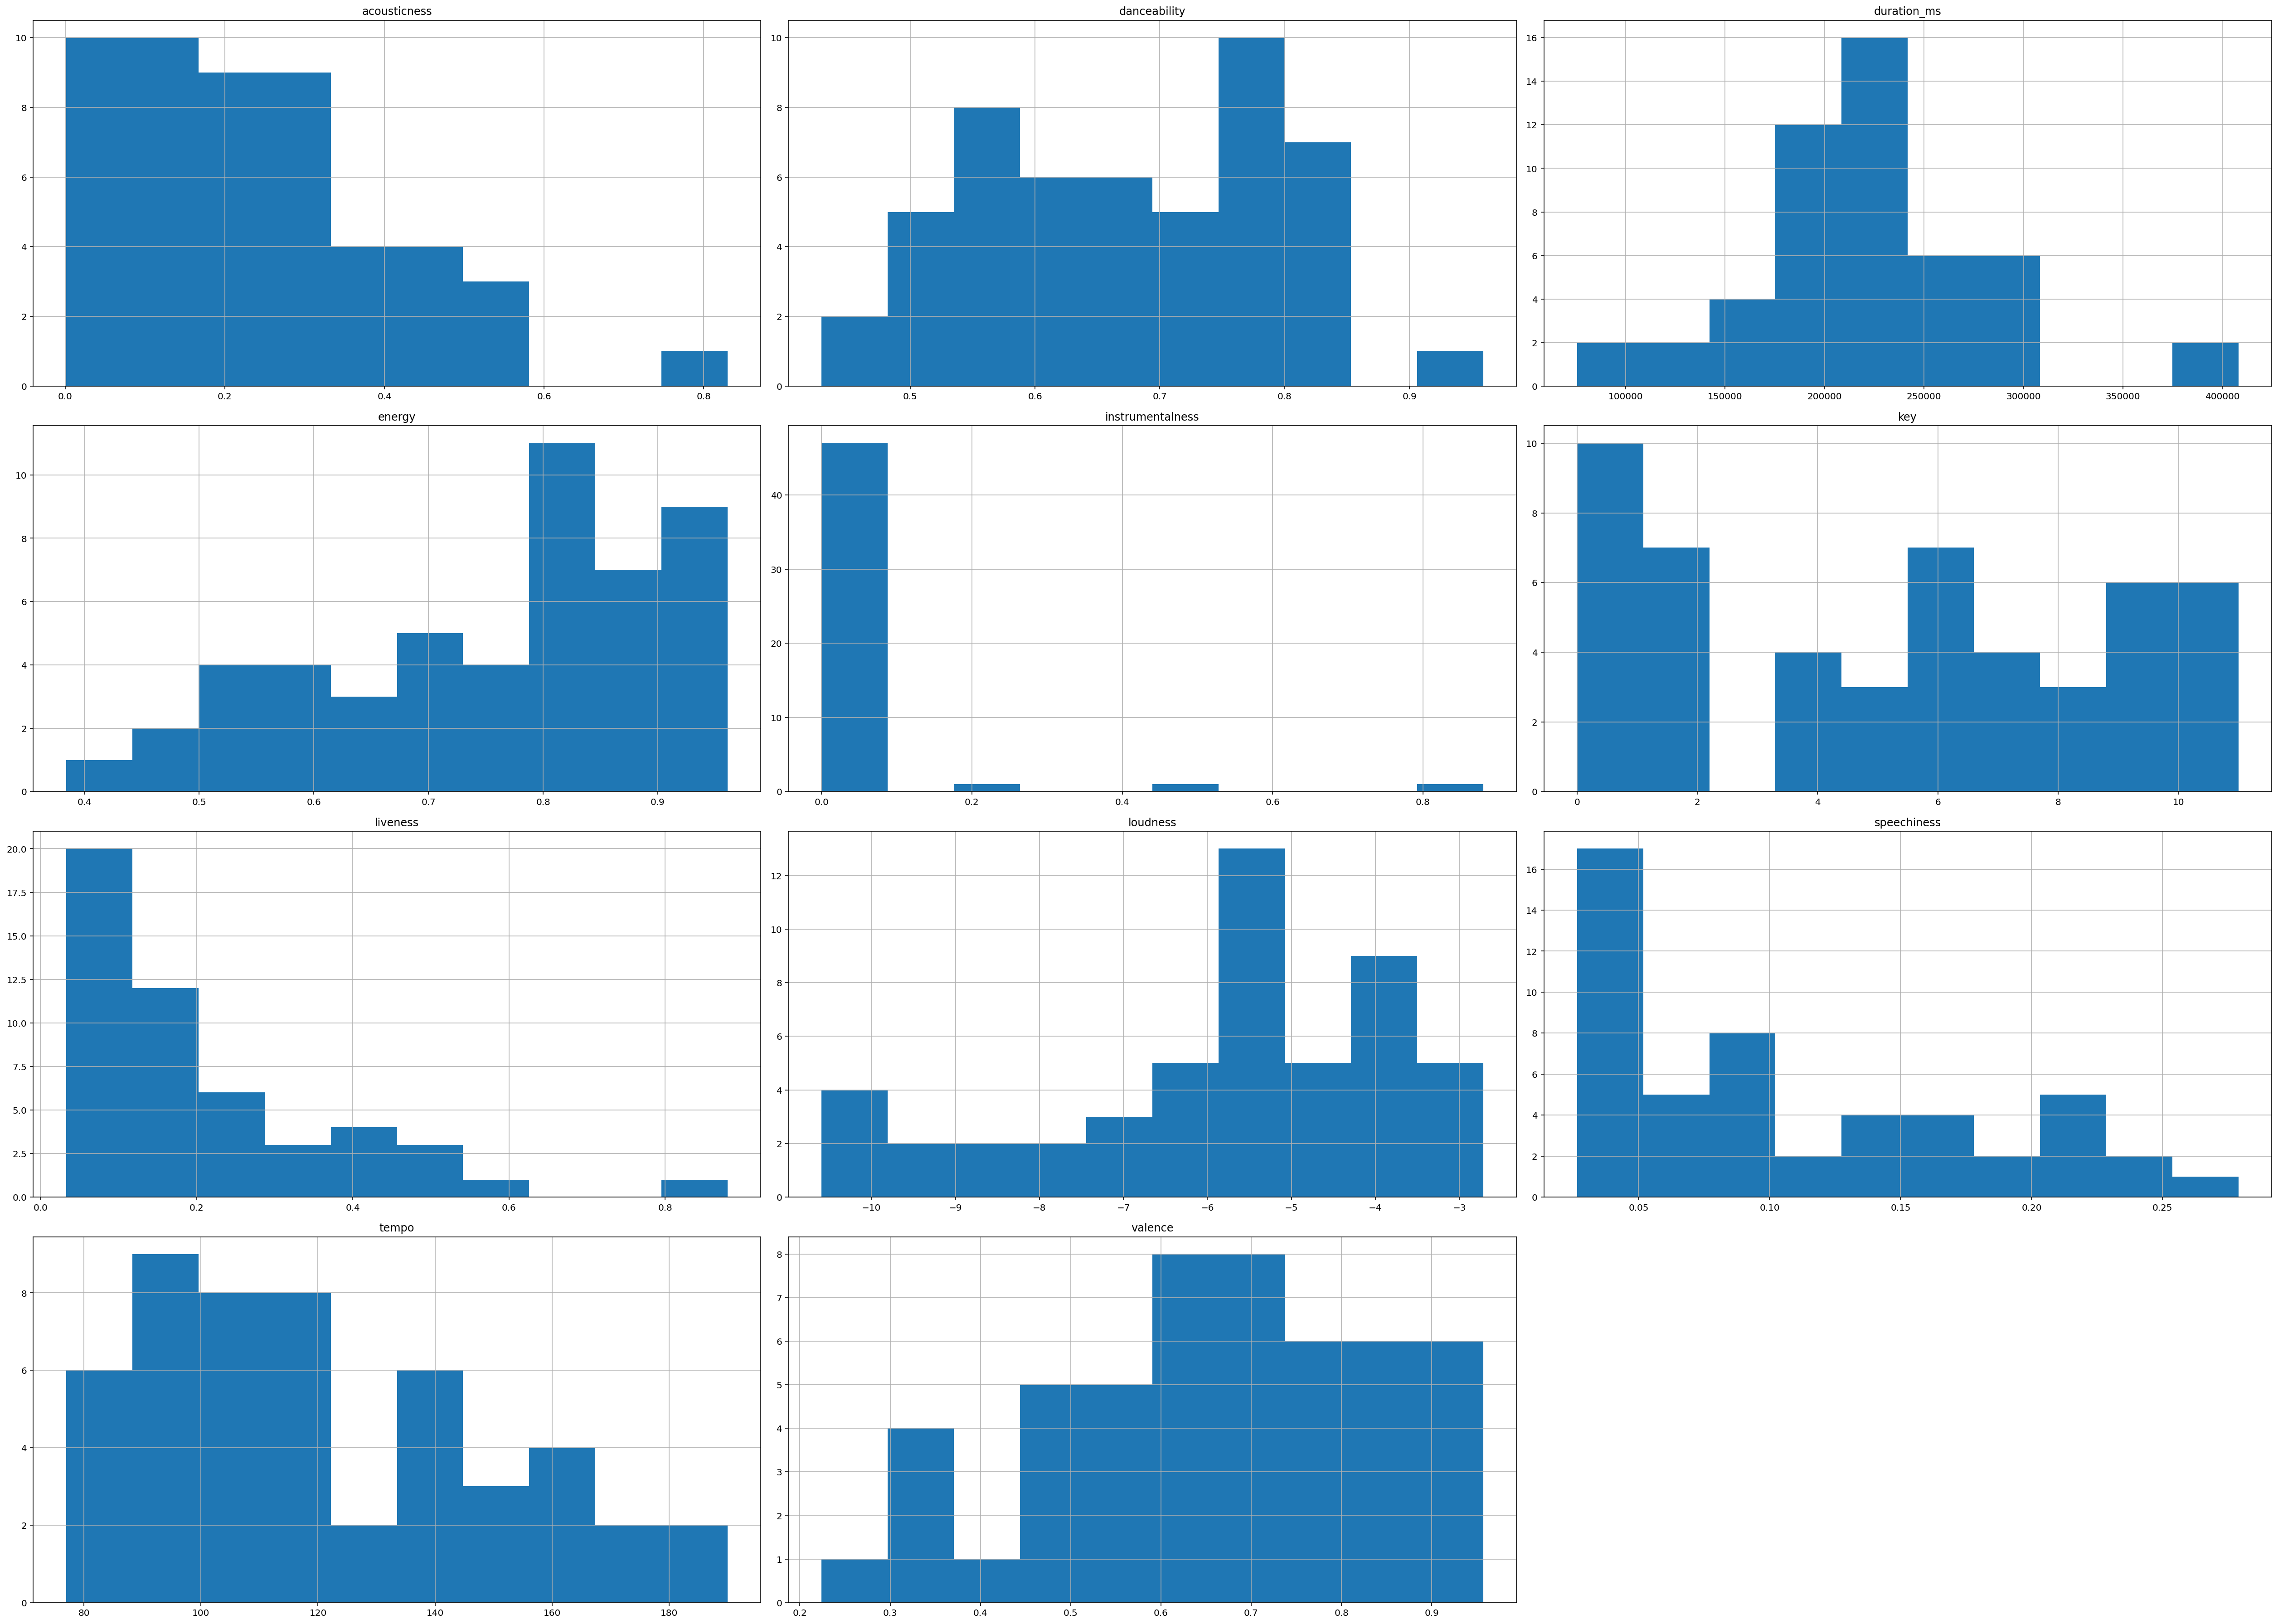

In [334]:
df_final_features.hist(figsize=(35,25)) 
plt.tight_layout()
plt.show()


## Playlist Extraction

### Featured Playlists Extraction

In [6]:
def featured_playlists(sp):
    id = []
    name = []
    num_tracks = []
    
    featured = sp.featured_playlists(sp)
    playlists = featured['playlists']
    for i, items in enumerate(playlists['items']):
        id.append(items['id'])
        name.append(items['name'])
        num_tracks.append(items['tracks']['total'])
    
    df_playlists = pd.DataFrame({'playlist_id':id, 'playlist_name':name, '#tracks': num_tracks})
    return df_playlists

In [7]:
df_featured_playlists = featured_playlists(sp)
df_featured_playlists

,playlist_id,playlist_name,#tracks
0,37i9dQZF1DWZd79rJ6a7lp,Sleep,257
1,37i9dQZF1DX4bSrsRWE9cd,Bliss,74
2,37i9dQZF1DXbcPC6Vvqudd,Night Rain,220
3,37i9dQZF1DX6xOPeSOGone,Soft Rock,100
4,37i9dQZF1DWYcDQ1hSjOpY,Deep Sleep,258
5,37i9dQZF1DX7qK8ma5wgG1,Sad Songs,60
6,37i9dQZF1DX8Sz1gsYZdwj,Classical Sleep,72
7,37i9dQZF1DX5xiztvBdlUf,Truly Deeply House,80
8,37i9dQZF1DWUAeTOoyNaqm,ASMR Sleep,64
9,37i9dQZF1DX0Aaer4Jzfgm,Easy Classical,66


### User Playlists Extraction

In [298]:
def user_playlist(sp,username):
    playlist_id = []
    playlist_name = []
    num_tracks = []
    
    featured = sp.user_playlists(username)
    for i, items in enumerate(featured['items']):
        playlist_id.append(items['id'])
        playlist_name.append(items['name'])
        num_tracks.append(items['tracks']['total'])
    
    df_your_lib = pd.DataFrame({'playlist_id':playlist_id, 'playlist_name':playlist_name, '#tracks': num_tracks})
    return df_your_lib
        

In [299]:
df_user_playlists = user_playlist(sp,username)
searchfor = ['Custom', 'Discover']
df_user_playlists =  df_user_playlists[~df_user_playlists['playlist_name'].str.contains('|'.join(searchfor))]
df_user_playlists

,playlist_id,playlist_name,#tracks
0,37i9dQZF1DX5Ejj0EkURtP,All Out 10s,150
1,37i9dQZF1DXc6IFF23C9jj,Top Hits of 2010,100
2,37i9dQZF1EMdcXI0FdmrA0,Your Top Songs 2020,100
3,1B9BPUMWDtl4ASyG4f693s,Bruno Mars - Official Discography,38
4,37i9dQZF1DWWF3yivn1m3D,This Is Hans Zimmer,68
5,5acGzAC0OH4QDVj5hlFqlK,Study with Me,1030
6,37i9dQZF1DX64Y3du11rR1,Sad Covers,61
7,37i9dQZF1DXc3FQfFV3K6V,Laidback Acoustic,101
8,0vvXsWCC9xrXsKd4FyS8kM,lofi hip hop music - beats to relax/study to,309
9,37i9dQZF1DWWQRwui0ExPn,Lo-Fi Beats,450


## Fetch Tracks for each playlists

In [9]:
def get_playlist_tracks(sp, playlist_id):
    tracks = []
    offset = 0
    while True:
        track_list = sp.playlist_tracks(playlist_id, fields = None, limit = 100, offset = offset, market = None)
        tracks += track_list['items']
        
        if track_list['next'] is not None:
            offset +=100
        else:
            break
            
    track_id = []
    track_name = []
    
    try:
        for track in tracks:
            track_id.append(track['track']['id'])
            track_name.append(track['track']['name'])
    except:
            pass
    
    df_playlist_tracks = pd.DataFrame({'track_id':track_id, 'track_name': track_name})
    return df_playlist_tracks
    

## Get Audio Features for each track within a playlist

In [10]:
def get_audio_features(sp, playlist_id):
    playlist = get_playlist_tracks(sp, playlist_id)
    audio_features = []
    
    for i in range(len(playlist)):
        try:
            audio_features.append(sp.audio_features(playlist['track_id'][i]))
        except:
            pass
             
             
    feature_list = []
    for feature in audio_features:
        try:
            feature_list.append([feature[0]['danceability'],
                            feature[0]['energy'],
                            feature[0]['key'],
                            feature[0]['loudness'],
                            feature[0]['speechiness'],
                            feature[0]['acousticness'],
                            feature[0]['instrumentalness'],
                            feature[0]['liveness'],
                            feature[0]['valence'],
                            feature[0]['tempo'],
                            feature[0]['duration_ms']]
                               )
        except:
            pass

    df_audio_feature = pd.DataFrame(feature_list, columns = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 
                                                          'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
                                                          'duration_ms'])
    df_playlist_audio_features = pd.concat([playlist, df_audio_feature], axis=1)
    df_playlist_audio_features = df_playlist_audio_features.dropna()
    return df_playlist_audio_features
    

## Get the mean & merge each playlist

In [11]:
def get_audio_features_mean (sp, playlist_id):
    playlist = get_audio_features(sp, playlist_id)
    df_mean_playlist = pd.DataFrame(playlist.mean(),columns = [playlist_id])
    return df_mean_playlist

In [12]:
dataframes = []
for i in df_featured_playlists['playlist_id']:
    dataframes.append(get_audio_features_mean(sp, i))
    
dataframes
    

[                  37i9dQZF1DWZd79rJ6a7lp
 danceability                    0.185260
 energy                          0.038644
 key                             4.863813
 loudness                      -30.057572
 speechiness                     0.041844
 acousticness                    0.951167
 instrumentalness                0.886101
 liveness                        0.106140
 valence                         0.083682
 tempo                          84.251650
 duration_ms                185308.038911,
                   37i9dQZF1DX4bSrsRWE9cd
 danceability                    0.495473
 energy                          0.235396
 key                             3.770270
 loudness                      -14.778986
 speechiness                     0.038682
 acousticness                    0.816699
 instrumentalness                0.164258
 liveness                        0.133188
 valence                         0.248828
 tempo                         117.758108
 duration_ms                23124

In [304]:
dataframes_user = []
for i in df_user_playlists['playlist_id']:
    dataframes_user.append(get_audio_features_mean(sp, i))
    
dataframes_user


[                  37i9dQZF1DX5Ejj0EkURtP
 danceability                    0.655820
 energy                          0.662243
 key                             5.366667
 loudness                       -5.620827
 speechiness                     0.086055
 acousticness                    0.181648
 instrumentalness                0.003914
 liveness                        0.147037
 valence                         0.490226
 tempo                         119.850493
 duration_ms                209190.806667,
                   37i9dQZF1DXc6IFF23C9jj
 danceability                    0.641090
 energy                          0.751320
 key                             5.260000
 loudness                       -4.987220
 speechiness                     0.095363
 acousticness                    0.116672
 instrumentalness                0.003646
 liveness                        0.195073
 valence                         0.565710
 tempo                         117.952870
 duration_ms                22678

In [30]:
X = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes)
X = X[:10]
X = X.drop('instrumentalness', axis=0)
X

,37i9dQZF1DWZd79rJ6a7lp,37i9dQZF1DX4bSrsRWE9cd,37i9dQZF1DXbcPC6Vvqudd,37i9dQZF1DX6xOPeSOGone,37i9dQZF1DWYcDQ1hSjOpY,37i9dQZF1DX7qK8ma5wgG1,37i9dQZF1DX8Sz1gsYZdwj,37i9dQZF1DX5xiztvBdlUf,37i9dQZF1DWUAeTOoyNaqm,37i9dQZF1DX0Aaer4Jzfgm,37i9dQZF1DWXmlLSKkfdAk,37i9dQZF1DWUZ5bk6qqDSy
danceability,0.185260,0.495473,0.143090,0.543950,0.158340,0.508950,0.300836,0.709000,0.476612,0.212738,0.553337,0.075192
energy,0.038644,0.235396,0.744021,0.531210,0.075285,0.362172,0.039274,0.698938,0.270312,0.063185,0.288466,0.225514
key,4.863813,3.770270,4.313636,4.940000,4.713178,5.933333,4.638889,5.962500,3.687500,5.075758,5.024540,4.747475
loudness,-30.057572,-14.778986,-21.932473,-8.870700,-27.725345,-9.175383,-30.023417,-9.686175,-34.300563,-26.020561,-10.936331,-26.061717
speechiness,0.041844,0.038682,0.082850,0.034069,0.046178,0.050033,0.048289,0.056446,0.224439,0.044608,0.042837,0.041390
acousticness,0.951167,0.816699,0.226699,0.325898,0.893014,0.673183,0.970972,0.088157,0.271781,0.923121,0.745220,0.604397
liveness,0.106140,0.133188,0.602012,0.141781,0.103958,0.143207,0.098786,0.130776,0.223853,0.112347,0.150069,0.198492
valence,0.083682,0.248828,0.015402,0.416300,0.060357,0.278823,0.147419,0.290386,0.082288,0.090265,0.339958,0.017866
tempo,84.251650,117.758108,90.886027,117.383340,92.757919,123.478983,99.772236,123.677937,100.474734,101.519697,115.993982,57.318485


In [376]:
X_2 = reduce(lambda left,right: pd.merge(left,right, left_index=True, right_index=True), dataframes_user)
X_2 = X_2[:10]
X_2

,37i9dQZF1DX5Ejj0EkURtP,37i9dQZF1DXc6IFF23C9jj,37i9dQZF1EMdcXI0FdmrA0,1B9BPUMWDtl4ASyG4f693s,37i9dQZF1DWWF3yivn1m3D,5acGzAC0OH4QDVj5hlFqlK,37i9dQZF1DX64Y3du11rR1,37i9dQZF1DXc3FQfFV3K6V,0vvXsWCC9xrXsKd4FyS8kM,37i9dQZF1DWWQRwui0ExPn,...,1dMyrAIsCdMvqRupu27Bfi,6TIYmDn8GP5tbhtm0xDuRx,6Hmuuko1DY7cULrpeFeSkd,37i9dQZF1DWXmlLSKkfdAk,74sUjcvpGfdOvCHvgzNEDO,6A3Q5iGA2RvNqzdygcUvmd,37i9dQZF1DX9sIqqvKsjG8,7tWeLQSWPitehz4jTCWtrB,61pi0dy9neeNT1vwrWIoxL,1SZ70MXbfW10nDAa07xMFk
danceability,0.655820,0.641090,0.664510,0.694000,0.259207,0.251167,0.543180,0.561455,0.633019,0.678338,...,0.645260,0.542667,0.558246,0.553337,0.651100,0.278837,0.368625,0.353136,0.677889,0.661772
energy,0.662243,0.751320,0.676670,0.684921,0.265499,0.199991,0.196211,0.257869,0.236528,0.331056,...,0.576648,0.523000,0.406340,0.288466,0.292954,0.342122,0.053097,0.130256,0.685144,0.644173
key,5.366667,5.260000,5.220000,3.815789,4.764706,4.955078,4.868852,5.435644,5.475728,5.355556,...,5.053068,6.000000,4.845938,5.024540,5.688000,5.265306,5.227425,4.615385,4.500000,5.219634
loudness,-5.620827,-4.987220,-6.566740,-5.497132,-18.825971,-20.003024,-12.353672,-10.971139,-14.754540,-12.427378,...,-8.043822,-12.111167,-10.728331,-10.936331,-13.288876,-12.594980,-26.196712,-20.196718,-7.264111,-7.564875
speechiness,0.086055,0.095363,0.077950,0.066234,0.046128,0.043549,0.037708,0.044650,0.088642,0.124382,...,0.057797,0.055317,0.044462,0.042837,0.108445,0.032437,0.046009,0.054914,0.195794,0.087321
acousticness,0.181648,0.116672,0.262011,0.176828,0.530714,0.726229,0.852082,0.813079,0.722039,0.614101,...,0.414359,0.427667,0.582018,0.745220,0.544721,0.564365,0.990839,0.870842,0.275822,0.354046
instrumentalness,0.003914,0.003646,0.010617,0.000310,0.784516,0.836103,0.004356,0.010340,0.817682,0.762774,...,0.012732,0.736383,0.046264,0.014855,0.769179,0.755729,0.923629,0.884042,0.052792,0.010093
liveness,0.147037,0.195073,0.153269,0.162055,0.136641,0.128580,0.125195,0.143969,0.149436,0.152775,...,0.146210,0.118850,0.137164,0.150069,0.146628,0.153243,0.107383,0.120472,0.128772,0.164132
valence,0.490226,0.565710,0.545569,0.657184,0.099951,0.101162,0.267602,0.359441,0.248281,0.407510,...,0.543604,0.329650,0.394676,0.339958,0.361004,0.309059,0.246907,0.166490,0.596389,0.578980
tempo,119.850493,117.952870,119.529760,124.702158,108.392926,102.738502,113.446525,116.026040,104.126172,104.910611,...,118.439920,117.551167,117.410314,115.993982,111.185436,114.189551,121.729341,105.345218,115.543167,117.739065


In [31]:
y = pd.DataFrame(df_final_features.mean(), columns = ['top_playlist'])
y = y[:10]
y = y.drop('instrumentalness', axis=0)
y

,top_playlist
danceability,0.671060
energy,0.754080
key,5.200000
loudness,-5.817680
speechiness,0.106166
acousticness,0.235979
liveness,0.207758
valence,0.661100
tempo,120.519860


## Memory Based Collaborative Filter

### Euclidean Distance - Featured

In [32]:
#Euclidian distance takes the magnitude of each element within the vector into consideration 
def euclidean_distance(user_playlist,featured_playlist):    
    x = np.sqrt(np.sum((user_playlist - featured_playlist) ** 2))
    return x

In [33]:
def euc_dataframe(user_playlist):
    featured = []
    distance_score = []
    for i in df_featured_playlists['playlist_id']:
        featured.append(i)
        distance_score.append(euclidean_distance(user_playlist,X[i]))
    df_euc_dist = pd.DataFrame({'featured_playlist':featured, 'distance_score':distance_score})
    sort_values = df_euc_dist.sort_values('distance_score', ascending = True)
    return sort_values

In [34]:
feat_dist = euc_dataframe(y['top_playlist'])
feat_top_3 = feat_dist.nsmallest(3,'distance_score')
feat_top_3

,featured_playlist,distance_score
3,37i9dQZF1DX6xOPeSOGone,4.401100
5,37i9dQZF1DX7qK8ma5wgG1,4.592693
7,37i9dQZF1DX5xiztvBdlUf,5.068754


### Euclidean Distance - User

In [390]:
def euc_dataframe(user_playlist):
    featured = []
    distance_score = []
    for i in df_user_playlists['playlist_id']:
        featured.append(i)
        distance_score.append(euclidean_distance(user_playlist,X_2[i]))
    df_euc_dist = pd.DataFrame({'featured_playlist':featured, 'distance_score':distance_score})
    sort_values = df_euc_dist.sort_values('distance_score', ascending = True)
    return sort_values

In [391]:
user_dist = euc_dataframe(y['top_playlist'])
user_dist = user_dist.drop(user_dist[user_dist['distance_score'] == 0.0000000].index)
user_top_3 = user_dist.nsmallest(3,'distance_score')
user_top_3

,featured_playlist,distance_score
0,37i9dQZF1DX5Ejj0EkURtP,0.748584
2,37i9dQZF1EMdcXI0FdmrA0,1.251459
18,11oxVoG1vqvCP6fiqKwXEV,1.676768


## Create playlist df

### Create df for featured playlists

In [18]:
for i, playlist in enumerate(df_featured_playlists['playlist_id']):
    try:
        string_command = "df_{} = get_audio_features(sp, playlist)".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass

Create df_37i9dQZF1DWZd79rJ6a7lp = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX4bSrsRWE9cd = get_audio_features(sp, playlist)
Create df_37i9dQZF1DXbcPC6Vvqudd = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX6xOPeSOGone = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWYcDQ1hSjOpY = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX7qK8ma5wgG1 = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX8Sz1gsYZdwj = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX5xiztvBdlUf = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWUAeTOoyNaqm = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX0Aaer4Jzfgm = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWXmlLSKkfdAk = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWUZ5bk6qqDSy = get_audio_features(sp, playlist)


### Create df for user playlists

In [314]:
for i, playlist in enumerate(df_user_playlists['playlist_id']):
    try:
        string_command = "df_{} = get_audio_features(sp, playlist)".format(playlist)
        print("Create {}".format(string_command))
        exec(string_command)
    except:
        print("playlist with id {} is not valid, skiping ".format(playlist))
        pass

Create df_37i9dQZF1DX5Ejj0EkURtP = get_audio_features(sp, playlist)
Create df_37i9dQZF1DXc6IFF23C9jj = get_audio_features(sp, playlist)
Create df_37i9dQZF1EMdcXI0FdmrA0 = get_audio_features(sp, playlist)
Create df_1B9BPUMWDtl4ASyG4f693s = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWWF3yivn1m3D = get_audio_features(sp, playlist)
Create df_5acGzAC0OH4QDVj5hlFqlK = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX64Y3du11rR1 = get_audio_features(sp, playlist)
Create df_37i9dQZF1DXc3FQfFV3K6V = get_audio_features(sp, playlist)
Create df_0vvXsWCC9xrXsKd4FyS8kM = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWWQRwui0ExPn = get_audio_features(sp, playlist)
Create df_37i9dQZF1DWYfvJNWU1bKi = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX8DxW4iib3Eq = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX177vQ7mVRmP = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX1riuLHc7Ui5 = get_audio_features(sp, playlist)
Create df_37i9dQZF1DX29brXfjEm5q = get_audio_fea

## Create Dataframe with top 3 playlists

### Featured Dataframe

In [36]:
frames_featured = [df_37i9dQZF1DX6xOPeSOGone, df_37i9dQZF1DX7qK8ma5wgG1, df_37i9dQZF1DX5xiztvBdlUf]
df =pd.concat(frames_featured)
df = df.set_index(['track_id'])
del df['track_name']
del df['duration_ms']
del df['instrumentalness']
df

,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo
track_id,,,,,,,,,
1HNywa8Bk0TmzRwQrzhtPo,0.556,0.528,4,-8.033,0.0266,0.61500,0.1220,0.163,159.821
5qfZRNjt2TkHEL12r3sDEU,0.534,0.445,4,-9.155,0.0292,0.45600,0.1120,0.136,146.107
2KPjz1SM7AWC9GxXHmRucG,0.480,0.500,11,-6.202,0.0280,0.52200,0.1930,0.410,149.957
2rF2dht1UkYFPpJ73w0AU6,0.589,0.633,7,-5.150,0.0235,0.00506,0.1720,0.479,84.063
7lGKEWMXVWWTt3X71Bv44I,0.389,0.665,0,-6.169,0.0644,0.17800,0.1160,0.199,117.055
...,...,...,...,...,...,...,...,...,...
68I3BQKCl5dx4gQOE4Du7r,0.652,0.645,8,-9.231,0.0391,0.00290,0.3300,0.462,122.017
3BQcbTWO7osx0CibVxnDv9,0.663,0.939,7,-6.093,0.0625,0.00156,0.0499,0.361,119.962
1imJVrrK1oCsdoJyijtLUv,0.723,0.478,2,-13.346,0.0410,0.02230,0.1360,0.032,116.000


### Calculate Std.Deviation of the top tracks to tracks in top 3 playlists

In [37]:
df1 = df.subtract(y['top_playlist'], axis ='columns')
df1 = df1 ** 2
df1['std_dev'] = df1.sum(axis=1)
df1['std_dev'].divide(len(df1))
np.sqrt(df1['std_dev'])
df1

,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,std_dev
track_id,,,,,,,,,,
1HNywa8Bk0TmzRwQrzhtPo,0.013239,0.051112,1.44,4.907643,0.006331,0.143657,0.007354,0.248104,1544.579605,1551.397045
5qfZRNjt2TkHEL12r3sDEU,0.018785,0.095530,1.44,11.137705,0.005924,0.048409,0.009170,0.275730,654.701733,667.732987
2KPjz1SM7AWC9GxXHmRucG,0.036504,0.064557,33.64,0.147702,0.006110,0.081808,0.000218,0.063051,866.545211,900.585161
2rF2dht1UkYFPpJ73w0AU6,0.006734,0.014660,3.24,0.445797,0.006834,0.053323,0.001279,0.033160,1329.102641,1332.904428
7lGKEWMXVWWTt3X71Bv44I,0.079558,0.007935,27.04,0.123426,0.001744,0.003362,0.008420,0.213536,12.005255,39.483236
...,...,...,...,...,...,...,...,...,...,...
68I3BQKCl5dx4gQOE4Du7r,0.000363,0.011898,7.84,11.650753,0.004498,0.054326,0.014943,0.039641,2.241428,21.857851
3BQcbTWO7osx0CibVxnDv9,0.000065,0.034195,3.24,0.075801,0.001907,0.054952,0.024919,0.090060,0.311208,3.833107
1imJVrrK1oCsdoJyijtLUv,0.002698,0.076220,10.24,56.675602,0.004247,0.045659,0.005149,0.395767,20.429134,87.874476


In [38]:
df2 = df1.sort_values('std_dev', ascending = True).head(50)
df2

,danceability,energy,key,loudness,speechiness,acousticness,liveness,valence,tempo,std_dev
track_id,,,,,,,,,,
6NWAAl3Awelh8I7cs4ud2w,0.024006,0.030948,0.04,1.067750,0.005136,0.054666,0.016017,0.065998,0.276529,1.581050
31mj62wEnU6stXSJ4yrUAL,0.015610,0.015109,0.64,0.023507,0.002320,0.055191,0.002998,0.135498,2.187855,3.078089
3BQcbTWO7osx0CibVxnDv9,0.000065,0.034195,3.24,0.075801,0.001907,0.054952,0.024919,0.090060,0.311208,3.833107
74ihDIAsUwAsYPYdWZH32P,0.000145,0.005030,3.24,1.376680,0.004156,0.000360,0.009753,0.049328,0.214499,4.899951
6pu5jQqenr37n0z6eBKOh0,0.010213,0.044487,0.64,0.877369,0.005093,0.055177,0.000046,0.263272,6.190841,8.086498
1W5NAzZUl8R6b99zAfZxC6,0.005616,0.007935,3.24,2.690650,0.004247,0.017418,0.054869,0.113636,2.229467,8.363839
0XgVoKbIlZRZ4S6ZVak1CN,0.004088,0.000672,7.84,2.011632,0.005266,0.055296,0.004728,0.098032,0.257922,10.277635
0uC4ZAfk05cmE3b6tLLhED,0.020147,0.000026,3.24,7.400141,0.002272,0.052002,0.010559,0.009235,0.222916,10.957298
1QQ3H25wbk4ayl9LUPWLme,0.009204,0.042403,10.24,1.580854,0.004826,0.038134,0.006203,0.171479,0.238281,12.331383


### User Dataframe

In [398]:
frames_user = [df_37i9dQZF1DX5Ejj0EkURtP, df_37i9dQZF1EMdcXI0FdmrA0, df_11oxVoG1vqvCP6fiqKwXEV]
frames_user
df_user =pd.concat(frames_user)
df_user = df_user.set_index(['track_id'])
del df_user['track_name']
del df_user['duration_ms']
df_user

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_id,,,,,,,,,,
1Slwb6dOYkBlWal1PGtnNg,0.781,0.445,2,-6.061,0.0295,0.4740,0.000000,0.1840,0.591,78.998
2GpHJb7xGNBaIDTrBxjIu6,0.665,0.759,0,-3.694,0.0399,0.0767,0.000000,0.3130,0.389,99.992
4evmHXcjt3bTUHD1cvny97,0.640,0.648,5,-8.113,0.1870,0.1240,0.000000,0.0802,0.548,92.977
6LsAAHotRLMOHfCsSfYCsz,0.692,0.809,2,-4.198,0.0602,0.5240,0.000000,0.1470,0.864,123.911
6v3KW9xbzN5yKLt9YKDYA2,0.759,0.548,9,-6.049,0.0290,0.0392,0.000000,0.0828,0.749,116.967
...,...,...,...,...,...,...,...,...,...,...
6OSaM7Cl9j4h1hg1YY6idE,0.742,0.913,5,-4.119,0.0716,0.2980,0.001940,0.1910,0.730,110.987
3Ss0h6wRTuYwnIPXOYa9bs,0.579,0.835,9,-4.436,0.1930,0.3110,0.000004,0.2160,0.437,124.083
7ENFYzur0PymEhwF15piWF,0.816,0.853,0,-6.401,0.0837,0.3150,0.004710,0.3480,0.936,132.983


### Calculate Std.Deviation of the top tracks to tracks in top 3 playlists

In [400]:
df_user1 = df_user.subtract(y['top_playlist'], axis ='columns')
df_user1 = df_user1 ** 2
df_user1['std_dev'] = df_user1.sum(axis=1)
df_user1['std_dev'].divide(len(df_user1))
np.sqrt(df_user1['std_dev'])
df_user1

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,variance
track_id,,,,,,,,,,,
1Slwb6dOYkBlWal1PGtnNg,0.012087,0.095530,10.24,0.059205,0.005878,0.056654,0.001138,0.000564,0.004914,1724.064858,1734.540828
2GpHJb7xGNBaIDTrBxjIu6,0.000037,0.000024,27.04,4.510017,0.004391,0.025370,0.001138,0.011076,0.074038,421.393036,453.059127
4evmHXcjt3bTUHD1cvny97,0.000965,0.011253,0.04,5.268494,0.006534,0.012539,0.001138,0.016271,0.012792,758.609137,763.979123
6LsAAHotRLMOHfCsSfYCsz,0.000438,0.003016,10.24,2.623363,0.002113,0.082956,0.001138,0.003692,0.041168,11.499830,24.497716
6v3KW9xbzN5yKLt9YKDYA2,0.007733,0.042469,14.44,0.053509,0.005955,0.038722,0.001138,0.015615,0.007726,12.622814,27.235681
...,...,...,...,...,...,...,...,...,...,...,...
6OSaM7Cl9j4h1hg1YY6idE,0.005032,0.025256,0.04,2.885514,0.001195,0.003847,0.001011,0.000281,0.004747,90.875420,93.842302
3Ss0h6wRTuYwnIPXOYa9bs,0.008475,0.006548,14.44,1.909040,0.007540,0.005628,0.001138,0.000068,0.050221,12.695967,29.124624
7ENFYzur0PymEhwF15piWF,0.021008,0.009785,27.04,0.340262,0.000505,0.006244,0.000842,0.019668,0.075570,155.329859,182.843743


In [402]:
df_user2 = df_user1.sort_values('variance', ascending = True).head(50)
df_user2

,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,variance
track_id,,,,,,,,,,,
5v7gCLVyLgpO5L6zdeXULd,3.878536e-02,0.006072,0.04,1.560800,0.000288,0.000440,0.001138,0.012003,0.021580,0.108149,1.789255
5GUM2uDH9Ey4aSvKz1lIdG,4.217204e-03,0.035314,0.04,1.843295,0.006215,0.011029,0.001132,0.000248,0.080032,0.131667,2.153150
0MU3DZ68Y09aNseo2e8JJJ,2.990824e-02,0.014622,1.44,1.668437,0.000890,0.145177,0.001138,0.015242,0.085206,0.267144,3.667764
2FbaDGEi0rA1AB3bieJKuk,4.925736e-02,0.000098,3.24,0.214999,0.001820,0.002599,0.002076,0.020580,0.000778,0.243898,3.776107
3rVBZoeJT4lIr1S9EeENtc,5.467124e-03,0.018747,1.44,0.060359,0.004104,0.015134,0.000461,0.010766,0.059000,2.265446,3.879485
2iUXsYOEPhVqEBwsqP70rE,5.634004e-03,0.009984,3.24,0.495166,0.127331,0.047995,0.001138,0.007015,0.259183,0.060447,4.253893
39IsH7B5byx8NRlEKlZVg9,1.020164e-03,0.012978,3.24,1.337909,0.005939,0.007392,0.009656,0.010766,0.005170,0.260243,4.891072
4nVBt6MZDDP6tRVdQTgxJg,5.049524e-03,0.008296,4.84,0.000246,0.003418,0.000121,0.001138,0.007878,0.140700,0.302654,5.309500
4lYKuF88iTBrppJoq03ujE,7.045924e-03,0.001438,1.44,4.497284,0.000599,0.053527,0.001138,0.031350,0.042808,0.289293,6.364482


## Create Discover Playlist

In [39]:
def create_playlist (sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)
    return playlists

In [40]:
today = str(date.today())
playlist_name = 'Discover Playlist ' + today
disc_pl = create_playlist(sp,username, playlist_name, 'Data Based Discover Playlist Created')
disc_code = disc_pl['uri']
disc_link = disc_code.partition("playlist:")[2]

In [41]:
def custom_playlist(sp, username, playlist_id, playlist_tracks):
    results = []
    results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[0:50])
    

In [42]:
disc_tracklist = df2.index
custom_playlist (sp, username, disc_link , disc_tracklist)

## Create Custom Playlist

In [403]:
today = str(date.today())
playlist_name2 = 'Custom Playlist ' + today
custom_pl = create_playlist(sp,username, playlist_name2, 'Data Based Custom Playlist Created')
custom_code = custom_pl['uri']
custom_link = custom_code.partition("playlist:")[2]

In [404]:
def custom_playlist(sp, username, playlist_id, playlist_tracks):
    results = []
    results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[0:50])

In [405]:
cust_tracklist = df_user2.index
custom_playlist (sp, username, custom_link , cust_tracklist)